# 01. Neural Nets with Keras

In this notebook you will learn how to implement neural networks using the Keras API. We will use TensorFlow's own implementation, *tf.keras*, which comes bundled with TensorFlow.

Don't hesitate to look at the documentation at [keras.io](https://keras.io/). All the code examples should work fine with tf.keras, the only difference is how to import Keras:

```python
# keras.io code:
from keras.layers import Dense
output_layer = Dense(10)

# corresponding tf.keras code:
from tensorflow import keras
Dense = keras.layers.Dense
output_layer = Dense(10)

# or simply:
from tensorflow import keras
output_layer = keras.layers.Dense(10)
```

In this notebook, we will not use any TensorFlow-specific code, so everything you see would run just the same way on [keras-team](https://github.com/keras-team/keras) or any other Python implementation of the Keras API (except for the imports).

## Imports

In [78]:
%matplotlib inline

In [79]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
matplotlib 3.0.2
numpy 1.15.4
pandas 0.24.0
sklearn 0.20.2
tensorflow 2.0.0-dev20190124
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

## Exercise 1 – TensorFlow Playground

Visit the [TensorFlow Playground](http://playground.tensorflow.org).
* **Layers and patterns**: try training the default neural network by clicking the "Run" button (top left). Notice how it quickly finds a good solution for the classification task. Notice that the neurons in the first hidden layer have learned simple patterns, while the neurons in the second hidden layer have learned to combine the simple patterns of the first hidden layer into more complex patterns). In general, the more layers, the more complex the patterns can be.
* **Activation function**: try replacing the Tanh activation function with the ReLU activation function, and train the network again. Notice that it finds a solution even faster, but this time the boundaries are linear. This is due to the shape of the ReLU function.
* **Local minima**: modify the network architecture to have just one hidden layer with three neurons. Train it multiple times (to reset the network weights, just add and remove a neuron). Notice that the training time varies a lot, and sometimes it even gets stuck in a local minimum.
* **Too small**: now remove one neuron to keep just 2. Notice that the neural network is now incapable of finding a good solution, even if you try multiple times. The model has too few parameters and it systematically underfits the training set.
* **Large enough**: next, set the number of neurons to 8 and train the network several times. Notice that it is now consistently fast and never gets stuck. This highlights an important finding in neural network theory: large neural networks almost never get stuck in local minima, and even when they do these local optima are almost as good as the global optimum. However, they can still get stuck on long plateaus for a long time.
* **Deep net and vanishing gradients**: now change the dataset to be the spiral (bottom right dataset under "DATA"). Change the network architecture to have 4 hidden layers with 8 neurons each. Notice that training takes much longer, and often gets stuck on plateaus for long periods of time. Also notice that the neurons in the highest layers (i.e. on the right) tend to evolve faster than the neurons in the lowest layers (i.e. on the left). This problem, called the "vanishing gradients" problem, can be alleviated using better weight initialization and other techniques, better optimizers (such as AdaGrad or Adam), or using Batch Normalization.
* **More**: go ahead and play with the other parameters to get a feel of what they do. In fact, after this course you should definitely play with this UI for at least one hour, it will grow your intuitions about neural networks significantly.

## Exercise 2 – Image classification with tf.keras

### Load the Fashion MNIST dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [80]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

The training set contains 55,000 grayscale images, each 28x28 pixels:

In [6]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented by a uint8 (byte) from 0 to 255:

In [8]:
#X_train[0]

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

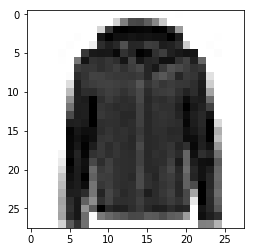

In [9]:
plt.imshow(X_train[0], cmap="binary")
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [10]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [81]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [12]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [13]:
X_valid.shape

(5000, 28, 28)

In [14]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

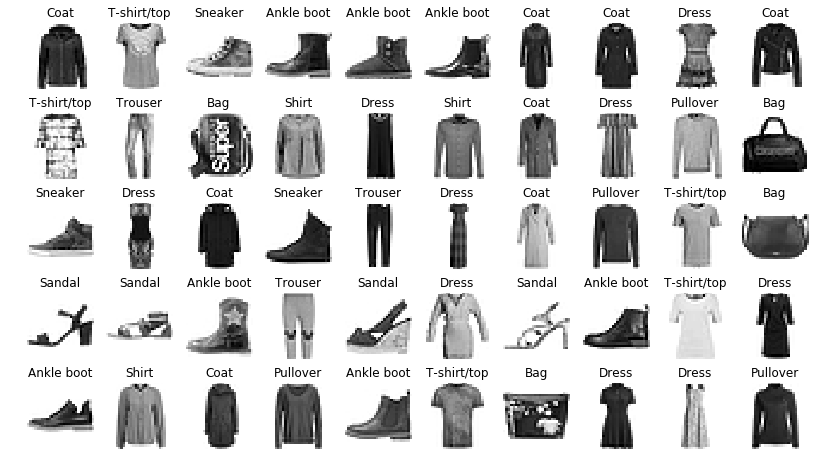

In [15]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

This dataset has the same structure as the famous MNIST dataset (which you can load using `keras.datasets.mnist.load_data()`), except the images represent fashion items rather than handwritten digits, and it is much more challenging. A simple linear model can reach 92% accuracy on MNIST, but only 83% on fashion MNIST.

### Build a classification neural network with Keras

### 2.1)

Build a `Sequential` model (`keras.models.Sequential`), without any argument, then and add four layers to it by calling its `add()` method:

* a `Flatten` layer (`keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
* a `Dense` layer  (`keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
* Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
* A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [82]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### 2.2)

Alternatively, you can pass a list containing the 4 layers to the constructor of the `Sequential` model. The model's `layers` attribute holds the list of layers.

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.layers

### 2.3)
Call the model's `summary()` method and examine the output. Also, try using `keras.utils.plot_model()` to save an image of your model's architecture. Alternatively, you can uncomment the following code to display the image within Jupyter.

In [83]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_182 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_183 (Dense)            (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [27]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [ ]:
%%html
<img src="my_mnist_model.png" />

**Warning**: at the present, you need `from tensorflow.python.keras.utils.vis_utils import model_to_dot`, instead of simply `keras.utils.model_to_dot`. See [TensorFlow issue 24639](https://github.com/tensorflow/tensorflow/issues/24639).

In [24]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 2.4)
After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `"sgd"` optimizer (stochastic gradient descent). Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case you should specify `metrics=["accuracy"]`. **Note**: you can find more loss functions in `keras.losses`, more metrics in `keras.metrics` and more optimizers in `keras.optimizers`.

In [84]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

### 2.5)
Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass the validation data by setting `validation_data=(X_valid, y_valid)`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [85]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000==============================] - 7s 126us/sample - loss: 3.7171 - acc: 0.5867 - val_loss: 0.9384 - val_acc: 0.6914
Epoch 2/10
55000/55000==============================] - 5s 88us/sample - loss: 0.7478 - acc: 0.7073 - val_loss: 0.7157 - val_acc: 0.7268
Epoch 3/10
55000/55000==============================] - 5s 87us/sample - loss: 0.6448 - acc: 0.7308 - val_loss: 0.6836 - val_acc: 0.7136
Epoch 4/10
55000/55000==============================] - 5s 88us/sample - loss: 0.6011 - acc: 0.7454 - val_loss: 0.6055 - val_acc: 0.7660
Epoch 5/10
55000/55000==============================] - 5s 88us/sample - loss: 0.5504 - acc: 0.7843 - val_loss: 0.5423 - val_acc: 0.8062
Epoch 6/10
55000/55000==============================] - 5s 87us/sample - loss: 0.5177 - acc: 0.7981 - val_loss: 0.5813 - val_acc: 0.7918
Epoch 7/10
55000/55000==============================] - 5s 88us/sample - loss: 0.4975 - acc: 0.8073 - val_loss: 0.5379 - val_acc

### 2.6)
Try running `pd.DataFrame(history.history).plot()` to plot the learning curves. To make the graph more readable, you can also set `figsize=(8, 5)`, call `plt.grid(True)` and `plt.gca().set_ylim(0, 1)`.

In [86]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

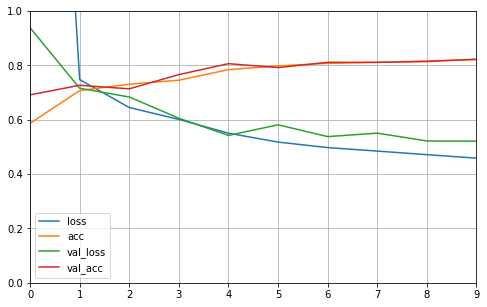

In [87]:
plot_learning_curves(history)

### 2.7)
Try running `model.fit()` again, and notice that training continues where it left off.

In [100]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000==============================] - 5s 89us/sample - loss: 0.4436 - acc: 0.8341 - val_loss: 0.5050 - val_acc: 0.8296
Epoch 2/10
55000/55000==============================] - 5s 89us/sample - loss: 0.4242 - acc: 0.8439 - val_loss: 0.5021 - val_acc: 0.8362
⋮
Epoch 9/10
55000/55000==============================] - 5s 87us/sample - loss: 0.3610 - acc: 0.8674 - val_loss: 0.4673 - val_acc: 0.8460
Epoch 10/10
55000/55000==============================] - 5s 87us/sample - loss: 0.3567 - acc: 0.8678 - val_loss: 0.4831 - val_acc: 0.8504



### 2.8)
Call the model's `evaluate()` method, passing it the test set (`X_test` and `y_test`). This will compute the loss (cross-entropy) on the test set, as well as all the additional metrics (in this case, the accuracy). Your model should achieve over 80% accuracy on the test set.

In [89]:
model.evaluate(X_test, y_test)

10000/10000==============================] - 1s 67us/sample - loss: 0.5029 - acc: 0.8320


[0.502902088022232, 0.832]

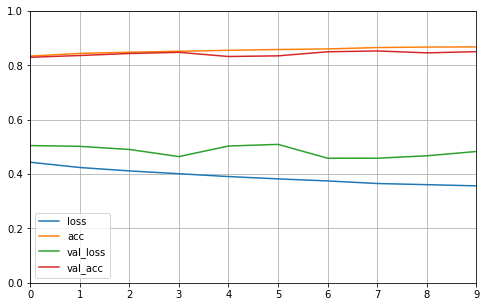

In [90]:
plot_learning_curves(history)

### 2.9)
Define `X_new` as the first 10 instances of the test set. Call the model's `predict()` method to estimate the probability of each class for each instance (for better readability, you may use the output array's `round()` method):

In [35]:
n_new = 10
X_new = X_test[:n_new]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.26, 0.  , 0.18, 0.01, 0.  , 0.  , 0.55, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

### 2.10)
Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [36]:
y_pred = y_proba.argmax(axis=1)
y_pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.11)
Call the model's `predict_classes()` method for `X_new`. You should get the same result as above.

In [37]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

### 2.12)
(Optional) It is often useful to know how confident the model is for each prediction. Try finding the estimated probability for each predicted class using `np.max()`.

In [38]:
y_proba.max(axis=1).round(2)

array([0.96, 1.  , 1.  , 1.  , 0.55, 1.  , 0.98, 0.99, 1.  , 1.  ],
      dtype=float32)

### 2.13)
(Optional) It is frequent to want the top k classes and their estimated probabilities rather just the most likely class. You can use `np.argsort()` for this.

In [39]:
k = 3
top_k = np.argsort(-y_proba, axis=1)[:, :k]
top_k

array([[9, 7, 5],
       [2, 6, 4],
       [1, 3, 6],
       [1, 3, 6],
       [6, 0, 2],
       [1, 3, 4],
       [4, 2, 6],
       [6, 4, 2],
       [5, 7, 3],
       [7, 5, 0]])

In [40]:
row_indices = np.tile(np.arange(len(top_k)), [k, 1]).T
y_proba[row_indices, top_k].round(2)

array([[0.96, 0.04, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.55, 0.26, 0.18],
       [1.  , 0.  , 0.  ],
       [0.98, 0.02, 0.  ],
       [0.99, 0.01, 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ]], dtype=float32)

## Exercise 3 – Scale the features

### 3.1)
When using Gradient Descent, it is usually best to ensure that the features all have a similar scale, preferably with a Normal distribution. Try to standardize the pixel values and see if this improves the performance of your neural network.

In [91]:
pixel_means = X_train.mean(axis = 0)
pixel_stds = X_train.std(axis = 0)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [92]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000==============================] - 5s 82us/sample - loss: 0.9365 - acc: 0.6931 - val_loss: 0.6361 - val_acc: 0.7834
⋮
Epoch 20/20
55000/55000==============================] - 4s 78us/sample - loss: 0.3388 - acc: 0.8790 - val_loss: 0.3607 - val_acc: 0.8718



In [44]:
model.evaluate(X_test_scaled, y_test)

10000/10000==============================] - 1s 58us/sample - loss: 0.3959 - acc: 0.8569


[0.39592802584171294, 0.8569]

### 3.2)
Plot the learning curves. Do they look better than earlier?

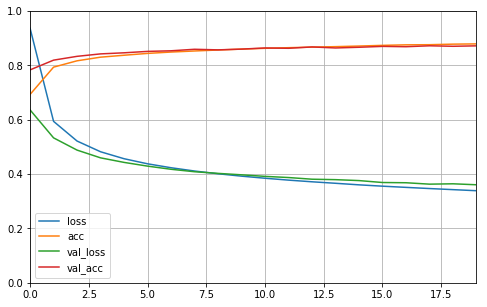

In [45]:
plot_learning_curves(history)

## Exercise 4 – Use Callbacks

### 4.1)
The `fit()` method accepts a `callbacks` argument. Try training your model with a large number of epochs, a validation set, and with a few callbacks from `keras.callbacks`:
* `TensorBoard`: specify a log directory. It should be a subdirectory of a root logdir, such as `./my_logs/run_1`, and it should be different every time you train your model. You can use a timestamp in the subdirectory's path to ensure that it changes at every run.
* `EarlyStopping`: specify `patience=5`
* `ModelCheckpoint`: specify the path of the checkpoint file to save (e.g., `"my_mnist_model.h5"`) and set `save_best_only=True`

Notice that the `EarlyStopping` callback will interrupt training before it reaches the requested number of epochs. This reduces the risk of overfitting.

In [48]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [49]:
logdir = os.path.join(root_logdir, "run_{}".format(time.time()))

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]
history = model.fit(X_train_scaled, y_train, epochs=50,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=callbacks)

### 4.2)
Run the following code (from this [StackOverflow answer](https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter/53978715#53978715)) to start a TensorBoard server and open a new tab to visualize the learning curve. When you are done, you can stop the tensorboard server by running `server.kill()`.

In [46]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [47]:
def tb(logdir=root_logdir, port=6006, open_tab=True, sleep=2):
    import subprocess
    proc = subprocess.Popen(
        "tensorboard --logdir={0} --port={1}".format(logdir, port), shell=True)
    if open_tab:
        import time
        time.sleep(sleep)
        import webbrowser
        webbrowser.open("http://127.0.0.1:{}/".format(port))
    return proc

In [ ]:
server = tb()

In [ ]:
server.kill()

### 4.3)
The early stopping callback only stopped training after 10 epochs without progress, so your model may already have started to overfit the training set. Fortunately, since the `ModelCheckpoint` callback only saved the best models (on the validation set), the last saved model is the best on the validation set, so try loading it using `keras.models.load_model()`. Finally evaluate it on the test set.

In [51]:
model = keras.models.load_model("my_mnist_model.h5")

In [52]:
model.evaluate(X_valid_scaled, y_valid)

5000/5000==============================] - 0s 75us/sample - loss: 0.3217 - acc: 0.8806


[0.3216999684602022, 0.8806]

### 4.4)
Look at the list of available callbacks at https://keras.io/callbacks/

## Exercise 5 – A neural net for regression

### 5.1)
Load the California housing dataset using `sklearn.datasets.fetch_california_housing`. This returns an object with a `DESCR` attribute describing the dataset, a `data` attribute with the input features, and a `target` attribute with the labels. The goal is to predict the price of houses in a district (a census block) given some stats about that district. This is a regression task (predicting values).

In [102]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [11]:
#print(housing.DESCR)

In [55]:
housing.data.shape

(20640, 8)

In [56]:
housing.target.shape

(20640,)

### 5.2)
Split the dataset into a training set, a validation set and a test set using Scikit-Learn's `sklearn.model_selection.train_test_split()` function.

In [103]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [58]:
len(X_train), len(X_valid), len(X_test)

(11610, 3870, 5160)

### 5.3)
Scale the input features (e.g., using a `sklearn.preprocessing.StandardScaler`). Once again, don't forget that you should not fit the validation set or the test set, only the training set.

In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### 5.4)
Now build, train and evaluate a neural network to tackle this problem. Then use it to make predictions on the test set.

In [60]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer="sgd")

In [93]:
callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test), epochs=100,
                    callbacks=callbacks)


Train on 11610 samples, validate on 5160 samples
Epoch 1/100
11610/11610==============================] - 1s 105us/sample - loss: 2.9974 - val_loss: 1.1305
⋮
Epoch 100/100
11610/11610==============================] - 1s 83us/sample - loss: 0.3713 - val_loss: 0.3658



In [62]:
model.evaluate(X_test_scaled, y_test)

5160/5160==============================] - 0s 45us/sample - loss: 0.3658


0.36577575493228526

In [63]:
model.predict(X_test_scaled)

array([[0.821453 ],
       [1.7315496],
       [3.785221 ],
       ...,
       [1.4291658],
       [2.3315072],
       [3.9124563]], dtype=float32)

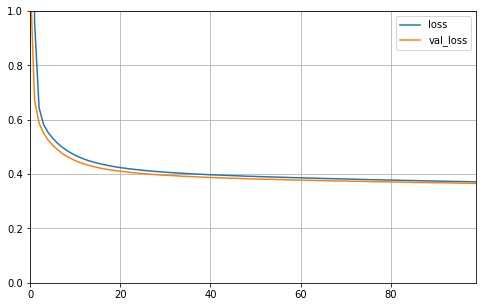

In [64]:
plot_learning_curves(history)

## Exercise 6 – Hyperparameter search

### 6.1)
Try training your model multiple times, with different a learning rate each time (e.g., 1e-4, 3e-4, 1e-3, 3e-3, 3e-2), and compare the learning curves. For this, you need to create a `keras.optimizers.SGD` optimizer and specify the `learning_rate` in its constructor, then pass this `SGD` instance to the `compile()` method using the `optimizer` argument.

In [116]:
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    callbacks = [keras.callbacks.EarlyStopping(patience=10)]
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_test_scaled, y_test), epochs=100,
                        callbacks=callbacks)
    histories.append(history)


Train on 11610 samples, validate on 5160 samples
Epoch 1/100
11610/11610==============================] - 3s 295us/sample - loss: 5.6342 - val_loss: 4.6069
⋮
Epoch 100/100
11610/11610==============================] - 1s 96us/sample - loss: 0.5444 - val_loss: 0.5399



In [108]:
#for learning_rate, history in zip(learning_rates, histories):
#    print("Learning rate:", learning_rate)
#    plot_learning_curves(history)

Learning rate: 0.0001


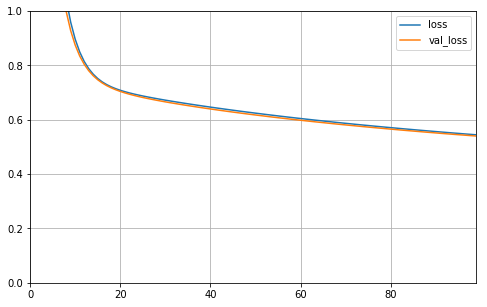

In [109]:
print(f'Learning rate: {learning_rates[0]}')
plot_learning_curves(histories[0])

Learning rate: 0.0003


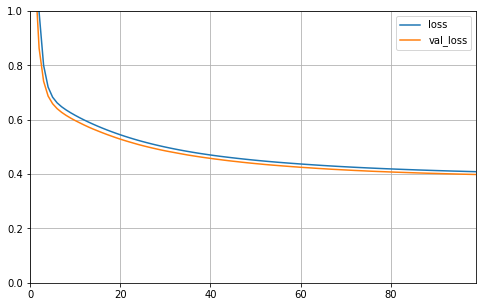

In [110]:
print(f'Learning rate: {learning_rates[1]}')
plot_learning_curves(histories[1])

Learning rate: 0.001


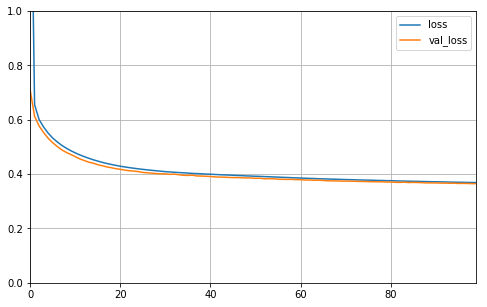

In [111]:
print(f'Learning rate: {learning_rates[2]}')
plot_learning_curves(histories[2])

Learning rate: 0.003


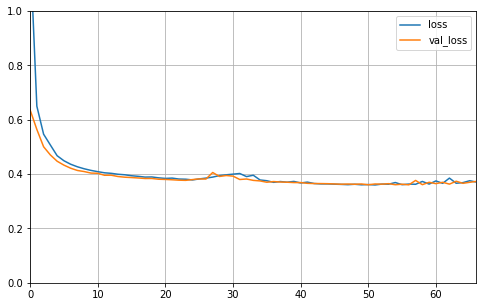

In [112]:
print(f'Learning rate: {learning_rates[3]}')
plot_learning_curves(histories[3])

Learning rate: 0.01


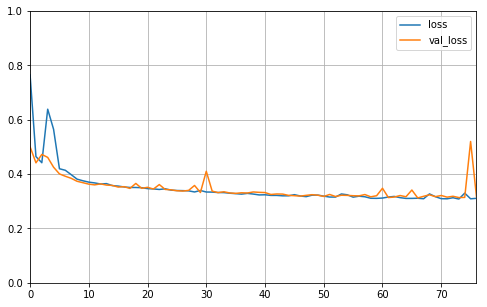

In [113]:
print(f'Learning rate: {learning_rates[4]}')
plot_learning_curves(histories[4])

Learning rate: 0.03


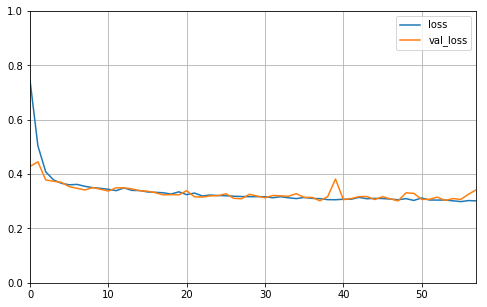

In [114]:
print(f'Learning rate: {learning_rates[5]}')
plot_learning_curves(histories[5])

### 6.2)
Let's look at a more sophisticated way to tune hyperparameters. Create a `build_model()` function that takes three arguments, `n_hidden`, `n_neurons`, `learning_rate`, and builds, compiles and returns a model with the given number of hidden layers, the given number of neurons and the given learning rate. It is good practice to give a reasonable default value to each argument.

In [69]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    options = {"input_shape": X_train.shape[1:]}
    for layer in range(n_hidden + 1):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

### 6.3)
Create a `keras.wrappers.scikit_learn.KerasRegressor` and pass the `build_model` function to the constructor. This gives you a Scikit-Learn compatible predictor. Try training it and using it to make predictions. Note that you can pass the `n_epochs`, `callbacks` and `validation_data` to the `fit()` method.

In [70]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [14]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 114us/sample - loss: 1.0804 - val_loss: 2.9145
⋮
Epoch 34/100
11610/11610==============================] - 1s 82us/sample - loss: 0.3336 - val_loss: 0.3769



In [72]:
keras_reg.predict(X_test_scaled)

array([0.6561703, 1.7545252, 4.2115364, ..., 1.5444285, 2.503292 ,
       3.9751492], dtype=float32)

### 6.4)
Use a `sklearn.model_selection.RandomizedSearchCV` to search the hyperparameter space of your `KerasRegressor`.

In [73]:
from scipy.stats import reciprocal

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [74]:
from sklearn.model_selection import RandomizedSearchCV

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)

In [76]:
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [ ]:
rnd_search_cv.best_params_

In [ ]:
rnd_search_cv.best_score_

In [ ]:
rnd_search_cv.best_estimator_

### 6.5)
Evaluate the best model found on the test set. You can either use the best estimator's `score()` method, or get its underlying Keras model *via* its `model` attribute, and call this model's `evaluate()` method. Note that the estimator returns the negative mean square error (it's a score, not a loss, so higher is better).

In [ ]:
rnd_search_cv.score(X_test_scaled, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test_scaled, y_test)

### 6.6)
Finally, save the best Keras model found. **Tip**: it is available via the best estimator's `model` attribute, and just need to call its `save()` method.

In [ ]:
model.save("my_fine_tuned_housing_model.h5")

**Tip**: while a randomized search is nice and simple, there are more powerful (but complex) options available out there for hyperparameter search, for example:
* [Hyperopt](https://github.com/hyperopt/hyperopt)
* [Hyperas](https://github.com/maxpumperla/hyperas)
* [Sklearn-Deap](https://github.com/rsteca/sklearn-deap)
* [Scikit-Optimize](https://scikit-optimize.github.io/)
* [Spearmint](https://github.com/JasperSnoek/spearmint)
* [PyMC3](https://docs.pymc.io/)
* [GPFlow](https://gpflow.readthedocs.io/)
* [Yelp/MOE](https://github.com/Yelp/MOE)
* Commercial services such as: [Google Cloud ML Engine](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning), [Arimo](https://arimo.com/) or [Oscar](http://oscar.calldesk.ai/)

## Exercise 7 – The functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer, as shown on the following diagram:

<img src="images/wide_and_deep_net.png" title="Wide and deep net" width=300 />

### 7.1)
Use Keras' functional API to implement a Wide & Deep network to tackle the California housing problem.

**Tips**:
* You need to create a `keras.layers.Input` layer to represent the inputs. Don't forget to specify the input `shape`.
* Create the `Dense` layers, and connect them by using them like functions. For example, `hidden1 = keras.layers.Dense(30, activation="relu")(input)` and `hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)`
* Use the `keras.layers.concatenate()` function to concatenate the input layer and the second hidden layer's output.
* Create a `keras.models.Model` and specify its `inputs` and `outputs` (e.g., `inputs=[input]`).
* Then use this model just like a `Sequential` model: you need to compile it, display its summary, train it, evaluate it and use it to make predictions.

In [8]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

In [9]:
model = keras.models.Model(inputs=[input], outputs=[output])

In [10]:
model.compile(loss="mean_squared_error", optimizer="sgd")

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [17]:
history = model.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_valid_scaled, y_valid))


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 2s 164us/sample - loss: 1.6848 - val_loss: 3.7498
⋮
Epoch 100/100
11610/11610==============================] - 1s 82us/sample - loss: 0.3405 - val_loss: 0.3513



In [15]:
model.evaluate(X_test_scaled, y_test)

5160/5160==============================] - 0s 45us/sample - loss: 0.3439


0.34394271697184836

In [16]:
model.predict(X_test_scaled)

array([[0.57043594],
       [1.5085149 ],
       [3.9963393 ],
       ...,
       [1.5062919 ],
       [2.316246  ],
       [4.0163803 ]], dtype=float32)

### 7.2)
After the Sequential API and the Functional API, let's try the Subclassing API:
* Create a subclass of the `keras.models.Model` class.
* Create all the layers you need in the constructor (e.g., `self.hidden1 = keras.layers.Dense(...)`).
* Use the layers to process the `input` in the `call()` method, and return the output.
* Note that you do not need to create a `keras.layers.Input` in this case.
* Also note that `self.output` is used by Keras, so you should use another name for the output layer (e.g., `self.output_layer`).

**When should you use the Subclassing API?**
* Both the Sequential API and the Functional API are declarative: you first declare the list of layers you need and how they are connected, and only then can you feed your model with actual data. The models that these APIs build are just static graphs of layers. This has many advantages (easy inspection, debugging, saving, loading, sharing, etc.), and they cover the vast majority of use cases, but if you need to build a very dynamic model (e.g., with loops or conditional branching), or if you want to experiment with new ideas using an imperative programming style, then the Subclassing API is for you. You can pretty much do any computation you want in the `call()` method, possibly with loops and conditions, using Keras layers of even low-level TensorFlow operations.
* However, this extra flexibility comes at the cost of less transparency. Since the model is defined within the `call()` method, Keras cannot fully inspect it. All it sees is the list of model attributes (which include the layers you define in the constructor), so when you display the model summary you just see a list of unconnected layers. Consequently, you cannot save or load the model without writing extra code. So this API is best used only when you really need the extra flexibility.

In [19]:
class MyModel(keras.models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden1 = keras.layers.Dense(30, activation="relu")
        self.hidden2 = keras.layers.Dense(30, activation="relu")
        self.output_ = keras.layers.Dense(1)

    def call(self, input):
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [20]:
model.compile(loss="mse", optimizer="sgd")

In [23]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  270       
_________________________________________________________________
dense_4 (Dense)              multiple                  930       
_________________________________________________________________
dense_5 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train_scaled, y_train, epochs=100,
                    validation_data=(X_valid_scaled, y_valid))


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 94us/sample - loss: 1.6064 - val_loss: 2.7035
⋮
Epoch 100/100
11610/11610==============================] - 1s 81us/sample - loss: 0.3368 - val_loss: 0.3584



In [24]:
model.evaluate(X_test_scaled, y_test)

5160/5160==============================] - 0s 47us/sample - loss: 0.3381


0.3380953616527624

In [25]:
model.predict(X_test_scaled)

array([[0.75208235],
       [1.8026717 ],
       [4.230581  ],
       ...,
       [1.5325407 ],
       [2.731325  ],
       [4.124872  ]], dtype=float32)

### 7.3)
Now suppose you want to send only features 0 to 4 directly to the output, and only features 2 to 7 through the hidden layers, as shown on the following diagram. Use the functional API to build, train and evaluate this model.

**Tips**:
* You need to create two `keras.layers.Input` (`input_A` and `input_B`)
* Build the model using the functional API, as above, but when you build the `keras.models.Model`, remember to set `inputs=[input_A, input_B]`
* When calling `fit()`, `evaluate()` and  `predict()`, instead of passing `X_train_scaled`, pass `(X_train_scaled_A, X_train_scaled_B)` (two NumPy arrays containing only the appropriate features copied from `X_train_scaled`).

<img src="images/multiple_inputs.png" title="Multiple inputs" width=300 />

In [26]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])

In [27]:
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)

In [28]:
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [29]:
model.compile(loss="mean_squared_error", optimizer="sgd")

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           210         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 30)           930         dense_6[0][0]                    
____________________________________________________________________________________________

In [31]:
X_train_scaled_A = X_train_scaled[:, :5]
X_train_scaled_B = X_train_scaled[:, 2:]
X_valid_scaled_A = X_valid_scaled[:, :5]
X_valid_scaled_B = X_valid_scaled[:, 2:]
X_test_scaled_A = X_test_scaled[:, :5]
X_test_scaled_B = X_test_scaled[:, 2:]

In [35]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], y_train, epochs=100,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], y_valid))


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 1s 101us/sample - loss: 1.8059 - val_loss: 0.9359
⋮
Epoch 100/100
11610/11610==============================] - 1s 84us/sample - loss: 0.3666 - val_loss: 0.3537



In [33]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], y_test)

5160/5160==============================] - 0s 47us/sample - loss: 0.3683


0.3682631360005963

In [34]:
model.predict([X_test_scaled_A, X_test_scaled_B])

array([[0.44141677],
       [1.8355198 ],
       [3.5486493 ],
       ...,
       [1.4929469 ],
       [2.5703018 ],
       [3.6846075 ]], dtype=float32)

### 7.4)
Build the multi-input and multi-output neural net represented in the following diagram.

<img src="images/multiple_inputs_and_outputs.png" title="Multiple inputs and outputs" width=400 />

**Why?**

There are many use cases in which having multiple outputs can be useful:
* Your task may require multiple outputs, for example, you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object's center, as well as its width and height) and a classification task.
* Similarly, you may have multiple independent tasks to perform based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks.
* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model's ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture (as shown in the diagram) to ensure that that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

**Tips**:
* Building the model is pretty straightforward using the functional API. Just make sure you specify both outputs when creating the `keras.models.Model`, for example `outputs=[output, aux_output]`.
* Each output has its own loss function. In this scenario, they will be identical, so you can either specify `loss="mse"` (this loss will apply to both outputs) or `loss=["mse", "mse"]`, which does the same thing.
* The final loss used to train the whole network is just a weighted sum of all loss functions. In this scenario, you want most to give a much smaller weight to the auxiliary output, so when compiling the model, you must specify `loss_weights=[0.9, 0.1]`.
* When calling `fit()` or `evaluate()`, you need to pass the labels for all outputs. In this scenario the labels will be the same for the main output and for the auxiliary output, so make sure to pass `(y_train, y_train)` instead of `y_train`.
* The `predict()` method will return both the main output and the auxiliary output.

In [40]:
input_A = keras.layers.Input(shape=[5])
input_B = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

In [41]:
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [42]:
model.compile(loss="mean_squared_error", loss_weights=[0.9, 0.1],
              optimizer="sgd")

In [43]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           210         input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           930         dense_9[0][0]                    
____________________________________________________________________________________________

In [45]:
history = model.fit([X_train_scaled_A, X_train_scaled_B], [y_train, y_train], epochs=100,
                    validation_data=([X_valid_scaled_A, X_valid_scaled_B], [y_valid, y_valid]))


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610==============================] - 2s 168us/sample - loss: 2.4151 - dense_11_loss: 2.1218 - dense_12_loss: 5.0473 - val_loss: 2.2815 - val_dense_11_loss: 1.3117 - val_dense_12_loss: 11.0056
⋮
Epoch 100/100
11610/11610==============================] - 2s 135us/sample - loss: 0.4042 - dense_11_loss: 0.3854 - dense_12_loss: 0.5737 - val_loss: 0.4096 - val_dense_11_loss: 0.3932 - val_dense_12_loss: 0.5556



In [47]:
model.evaluate([X_test_scaled_A, X_test_scaled_B], [y_test, y_test])

5160/5160==============================] - 0s 80us/sample - loss: 0.3961 - dense_11_loss: 0.3782 - dense_12_loss: 0.5544


[0.39608534371206, 0.3782187, 0.554439]

In [48]:
y_pred, y_pred_aux = model.predict([X_test_scaled_A, X_test_scaled_B])

In [49]:
y_pred

array([[0.5664863],
       [1.9437802],
       [3.4343388],
       ...,
       [1.5469277],
       [2.4339843],
       [3.7549822]], dtype=float32)

In [50]:
y_pred_aux

array([[0.9794607],
       [2.1019588],
       [2.7461283],
       ...,
       [1.3816206],
       [2.2232609],
       [3.120726 ]], dtype=float32)

## Exercise 8 – Deep Nets

Let's go back to Fashion MNIST and build deep nets to tackle it. We need to load it, split it and scale it.

In [51]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

### 8.1)
Build a sequential model with 20 hidden dense layers, with 100 neurons each, using the ReLU activation function, plus the output layer (10 neurons, softmax activation function). Try to train it for 10 epochs on Fashion MNIST and plot the learning curves. Notice that progress is very slow.

In [63]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [61]:
#model.summary()

In [99]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000==============================] - 8s 143us/sample - loss: 2.3021 - acc: 0.1221 - val_loss: 2.3018 - val_acc: 0.1840
Epoch 2/10
55000/55000==============================] - 7s 133us/sample - loss: 2.3010 - acc: 0.1941 - val_loss: 2.3002 - val_acc: 0.2186
⋮
Epoch 9/10
55000/55000==============================] - 7s 131us/sample - loss: 1.2508 - acc: 0.4892 - val_loss: 1.0176 - val_acc: 0.5776
Epoch 10/10
55000/55000==============================] - 7s 132us/sample - loss: 0.9554 - acc: 0.6159 - val_loss: 0.8543 - val_acc: 0.6800



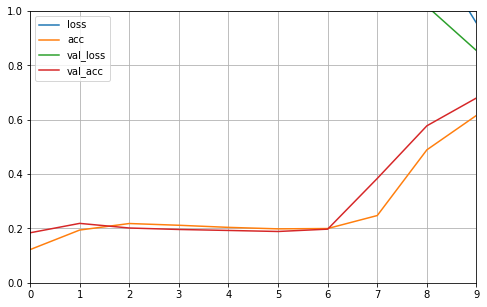

In [65]:
plot_learning_curves(history)

### 8.2)
Update the model to add a `BatchNormalization` layer after every hidden layer. Notice that performance progresses much faster per epoch, although computations are much more intensive. Display the model summary and notice all the non-trainable parameters (the scale $\gamma$ and offset $\beta$ parameters).

In [66]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])

In [67]:
#model.summary()

In [98]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000==============================] - 34s 616us/sample - loss: 2.0116 - acc: 0.3397 - val_loss: 1.1491 - val_acc: 0.6184
Epoch 2/10
55000/55000==============================] - 31s 568us/sample - loss: 1.1353 - acc: 0.6118 - val_loss: 0.8106 - val_acc: 0.7090
⋮
Epoch 9/10
55000/55000==============================] - 31s 558us/sample - loss: 0.6953 - acc: 0.7582 - val_loss: 0.5260 - val_acc: 0.8070
Epoch 10/10
55000/55000==============================] - 30s 553us/sample - loss: 0.6711 - acc: 0.7659 - val_loss: 0.5113 - val_acc: 0.8142



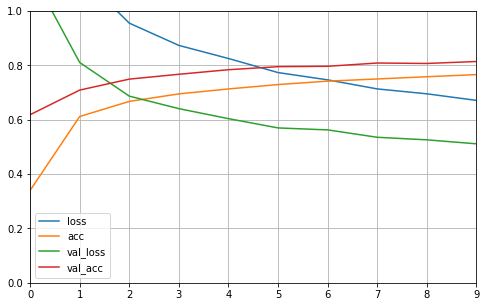

In [69]:
plot_learning_curves(history)

### 8.3)
Try moving the BN layers before the hidden layers' activation functions. Does this affect the model's performance?

In [97]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000==============================] - 34s 622us/sample - loss: 2.0136 - acc: 0.2954 - val_loss: 1.3146 - val_acc: 0.5580
Epoch 2/10
55000/55000==============================] - 30s 554us/sample - loss: 1.2595 - acc: 0.5810 - val_loss: 0.8565 - val_acc: 0.7150
⋮
Epoch 9/10
55000/55000==============================] - 32s 573us/sample - loss: 0.6552 - acc: 0.7770 - val_loss: 0.4895 - val_acc: 0.8270
Epoch 10/10
55000/55000==============================] - 30s 549us/sample - loss: 0.6373 - acc: 0.7817 - val_loss: 0.4783 - val_acc: 0.8284



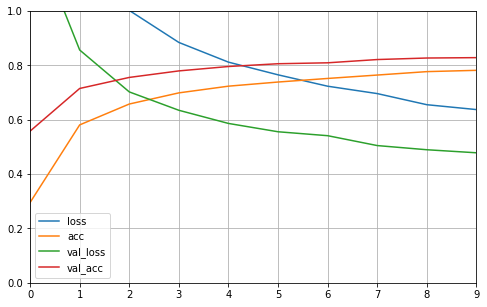

In [71]:
plot_learning_curves(history)

### 8.4)
Remove all the BN layers, and just use the SELU activation function instead. Notice that you get better performance than with BN but training is much faster. Isn't it marvelous? :-)

In [96]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000==============================] - 13s 231us/sample - loss: 0.6878 - acc: 0.7537 - val_loss: 0.4995 - val_acc: 0.8204
Epoch 2/10
55000/55000==============================] - 11s 193us/sample - loss: 0.4815 - acc: 0.8283 - val_loss: 0.4525 - val_acc: 0.8372
⋮
Epoch 9/10
55000/55000==============================] - 10s 191us/sample - loss: 0.3185 - acc: 0.8855 - val_loss: 0.3581 - val_acc: 0.8686
Epoch 10/10
55000/55000==============================] - 10s 191us/sample - loss: 0.3105 - acc: 0.8871 - val_loss: 0.3633 - val_acc: 0.8710



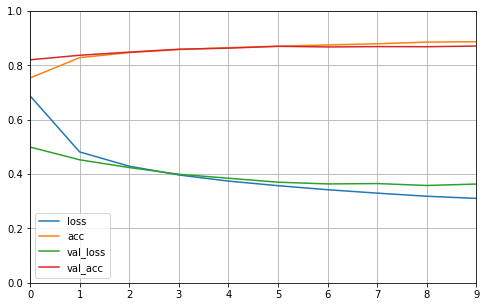

In [73]:
plot_learning_curves(history)

### 8.5)
Try training for 10 additional epochs, and notice that the model starts overfitting. Try adding a Dropout layer (with a 50% dropout rate) just before the output layer. Does it reduce overfitting? What about the final validation accuracy?

**Warning**: you should not use regular Dropout, as it breaks the self-normalizing property of the SELU activation function. Instead, use AlphaDropout, which is designed to work with SELU.

In [94]:
history = model.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000==============================] - 11s 197us/sample - loss: 0.3006 - acc: 0.8899 - val_loss: 0.3457 - val_acc: 0.8760
Epoch 2/10
55000/55000==============================] - 11s 192us/sample - loss: 0.2928 - acc: 0.8928 - val_loss: 0.3532 - val_acc: 0.8766
⋮
Epoch 9/10
55000/55000==============================] - 11s 195us/sample - loss: 0.2509 - acc: 0.9081 - val_loss: 0.3395 - val_acc: 0.8810
Epoch 10/10
55000/55000==============================] - 11s 192us/sample - loss: 0.2458 - acc: 0.9098 - val_loss: 0.3343 - val_acc: 0.8806



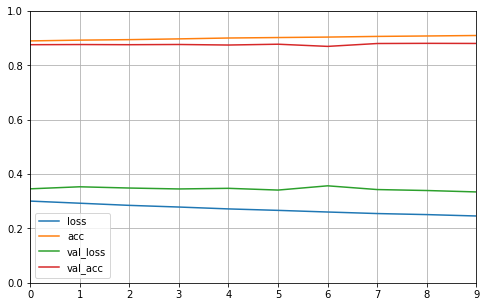

In [75]:
plot_learning_curves(history)

In [95]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_data=(X_valid_scaled, y_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000==============================] - 13s 238us/sample - loss: 1.1410 - acc: 0.6095 - val_loss: 0.7032 - val_acc: 0.8038
Epoch 2/20
55000/55000==============================] - 11s 202us/sample - loss: 0.6927 - acc: 0.7716 - val_loss: 0.6734 - val_acc: 0.8392
⋮
Epoch 19/20
55000/55000==============================] - 11s 198us/sample - loss: 0.3009 - acc: 0.8952 - val_loss: 0.5414 - val_acc: 0.8786
Epoch 20/20
55000/55000==============================] - 11s 199us/sample - loss: 0.2959 - acc: 0.8967 - val_loss: 0.5529 - val_acc: 0.8806



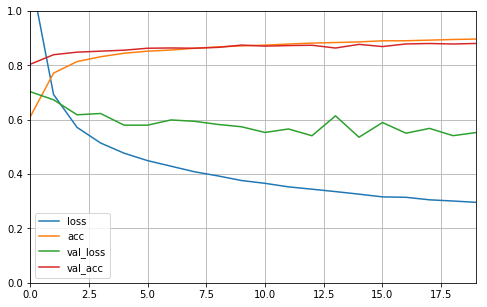

In [77]:
plot_learning_curves(history)